# Exploratory Data Analysis

In [30]:
import cv2
import numpy as np
import mediapipe as mp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from mediapipe.framework.formats import landmark_pb2
from mediapipe import solutions
from mediapipe.tasks import python
from mediapipe.tasks.python import vision

def draw_landmarks_on_image(rgb_image, pose_res):
    pose_lm = pose_res.pose_landmarks[0]
    image_res = np.copy(rgb_image)
    pose_landmarks_proto = landmark_pb2.NormalizedLandmarkList()
    pose_landmarks_proto.landmark.extend([
      landmark_pb2.NormalizedLandmark(x=landmark.x, y=landmark.y, z=landmark.z) for landmark in pose_lm
    ])
    solutions.drawing_utils.draw_landmarks(
      image_res,
      pose_landmarks_proto,
      solutions.pose.POSE_CONNECTIONS,
      solutions.drawing_styles.get_default_pose_landmarks_style())
    return image_res

def annotate_image(image_path):
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    mp_image = mp.Image(image_format=mp.ImageFormat.SRGB, data=image_rgb)
    pose_res = pose_landmarker.detect(mp_image)
    annotated_image = draw_landmarks_on_image(mp_image.numpy_view(), pose_res)
    return annotated_image

In [27]:
model_path = '../models/pose_landmarker_heavy.task'
base_options = python.BaseOptions(model_asset_path=model_path)
options = vision.PoseLandmarkerOptions(base_options=base_options)
pose_landmarker = vision.PoseLandmarker.create_from_options(options)

## Pose Keypoints
Pose keypoints plotted on various images

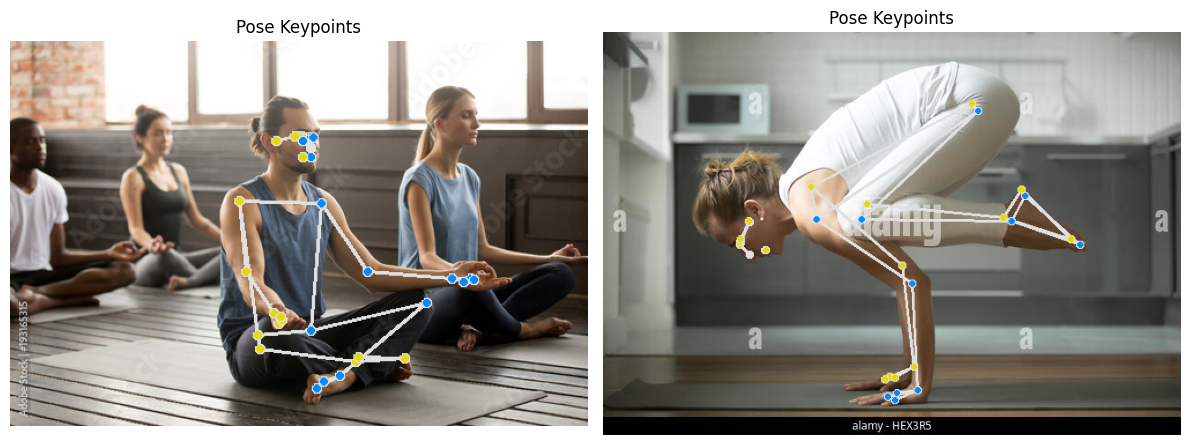

In [67]:
plt.figure(figsize=(12, 6))
image_paths = ['../data/raw/Sitting pose 1 (normal)/Sitting pose 1 (normal)_image_10.jpg',
               '../data/raw/Crane_(Crow)_Pose_or_Bakasana_/Crane_(Crow)_Pose_or_Bakasana__image_10.jpg'
               ]
for i, path in enumerate(image_paths):
    annotated_image = annotate_image(path)
    plt.subplot(1, 2, i + 1)
    plt.imshow(annotated_image)
    plt.title('Pose Keypoints')
    plt.axis('off')
plt.tight_layout()
plt.show()

## Pose Distribution
The histogram shows the number of samples for each pose. Some poses like Dolphin (55) and Pigeon (47) are underrepresented. We will use data augmentation to increase the number of samples per pose

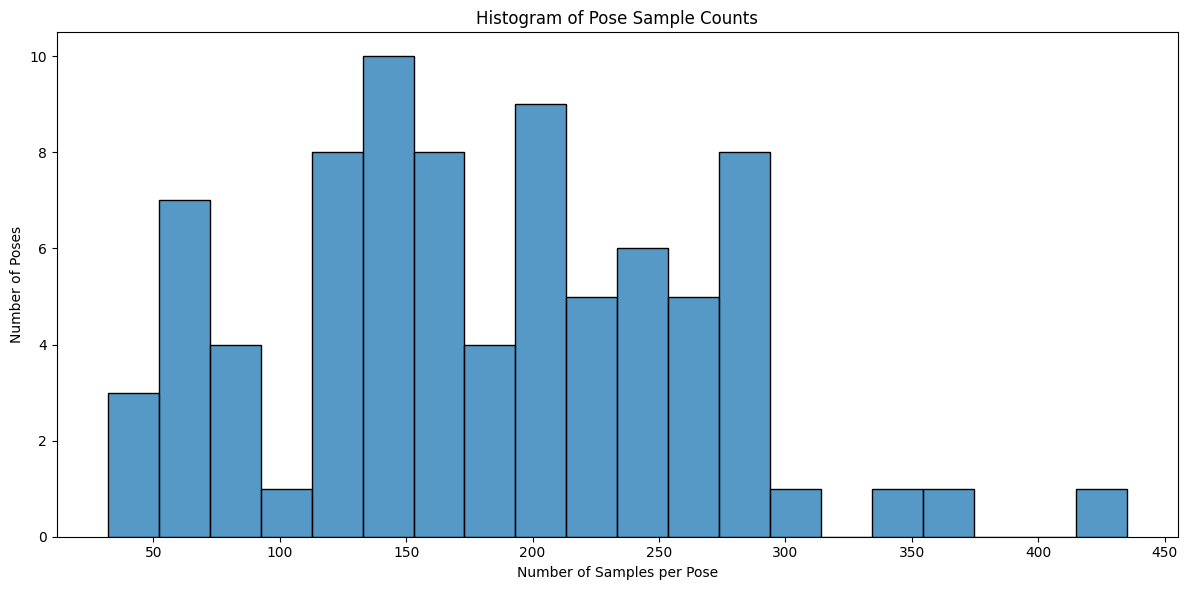

In [68]:
df = pd.read_parquet('../data/processed/df.parquet')
pose_counts = df['label'].value_counts()
plt.figure(figsize=(12, 6))
sns.histplot(pose_counts.values, bins=20)
plt.xlabel('Number of Samples per Pose')
plt.ylabel('Number of Poses')
plt.title('Histogram of Pose Sample Counts')
plt.tight_layout()
plt.show()

## Distribution of Keypoints per Pose
We plot the keypoints of 20 pose samples against the pose mean for the Warrior II pose. This shows us the intra-class variation of keypoints for this pose. The average keypoints are in line with what is expected. The sample keypoints of the feet are quite scattered suggesting that there is some variation in feet placement

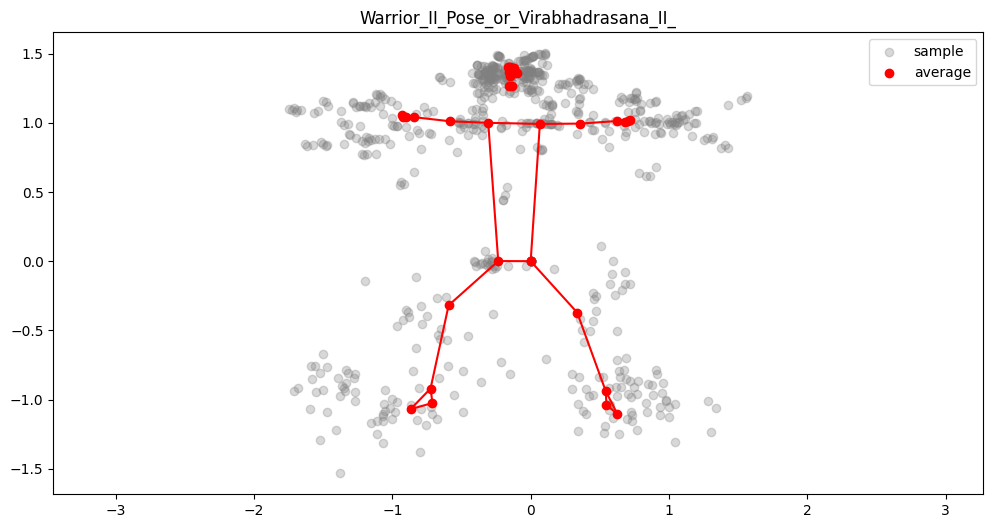

In [94]:
target_pose = 'Warrior_II_Pose_or_Virabhadrasana_II_'
pose_samples = df[df['label'] == target_pose].drop('label', axis=1)
pose_mean = df.mean()
pose_samples_np = pose_samples.values.reshape(-1, 33, 4)
pose_mean_np = pose_mean.values.reshape(33, 4)
n_samples = 20
plt.figure(figsize=(12, 6))
for i in range(min(n_samples, len(pose_samples_np))):
    kps = pose_samples_np[i]
    plt.scatter(kps[:,0], -kps[:,1], c='gray', alpha=0.3, label='sample' if i == 0 else "")

plt.scatter(pose_mean_np[:,0], -pose_mean_np[:,1], c='red', label='average')
for start_idx, end_idx in solutions.pose.POSE_CONNECTIONS:
    x = [pose_mean_np[start_idx, 0], pose_mean_np[end_idx, 0]]
    y = [-pose_mean_np[start_idx, 1], -pose_mean_np[end_idx, 1]]
    plt.plot(x, y, c='red')

plt.title(target_pose)
plt.legend()
plt.axis('equal')
plt.show()